In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'cmu serif'

page_width = 6.75 # aistats width

In [85]:
ds_name = 'cifar20_100' #'gtsrb' 'cifar10' 'cifar20_100'

In [86]:
results_path = f'../runs_final/{ds_name}/softmax'

In [87]:
# l2d_type_lst = ['single_finetune', 'single', 'pop']
l2d_type_lst = ['single', 'single_finetune', 'pop', 'pop_attn']
# l2d_type_lst = ['single', 'pop', 'pop_attn']
# p_out_lst = [0.1,0.2,0.4,0.6,0.8,0.95]
p_out_lst = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]

In [89]:
# budget_lst = [0.01,0.02,0.05,0.1,0.2,0.5,1.0]
budget_lst = [1.0]
seed_lst = [1071,3918,4420,5251,6637]
metrics_lst = ['cov', 'sys_acc', 'exp_acc', 'clf_acc', 'exp_acc_alone', 'clf_acc_alone', 'val_loss']

results = {}
for l2d_type in l2d_type_lst:
    results[l2d_type] = {}
    
    for budget in budget_lst:
        results[l2d_type][budget] = {}
        
        metrics_all = {metric:[[] for _ in range(len(p_out_lst))] for metric in metrics_lst}

        for ii,p_out in enumerate(p_out_lst):
            for seed in seed_lst:
                if l2d_type != 'single_finetune':
                    fn_path = os.path.join(results_path, f'l2d_{l2d_type}', f'p{p_out}_seed{seed}', f'eval{budget}.log')
                else:
                    fn_path = os.path.join(results_path, f'l2d_single', f'p{p_out}_seed{seed}', f'eval{budget}_finetune.log')

                try:
                    line = open(fn_path).readline().rstrip()
                except FileNotFoundError:
                    print(fn_path)
                else:
                    line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
                    for [metric,val] in line_split_grp:
                        if metric=='cov':
                            cov = val.split('/')
                            metrics_all[metric][ii].append(int(cov[0])/int(cov[1]))
                        else:
                            metrics_all[metric][ii].append(float(val))

        for metric, vals in metrics_all.items():
            results[l2d_type][budget][metric] = np.vstack(vals)

In [90]:
c_red = mpl.colormaps['Set1'](0)
c_blue = mpl.colormaps['Set1'](1)

In [91]:
metrics_to_text = {
    'cov':'Coverage',
    'sys_acc': 'System accuracy (\%)',
    'exp_acc': 'Expert accuracy\non deferred examples (\%)',
    'clf_acc': 'Classifier accuracy\n on non-deferred examples',
    'clf_acc_alone': 'Classifier accuracy\n on all examples',
    'val_loss': 'Test loss'
}

In [92]:
l2d_type_to_text = {
    'single': 'Single-expert',
    'single_finetune': 'Single-expert (finetune)',
    'pop': 'Population',
    'pop_attn': 'Pop. w/ attention',
}

In [93]:
# dataset_to_yticks_expacc = {
#     'cifar10' : [20,40,60,80,100]
# }

# dataset_to_yticks_sysacc = {
#     'cifar10' : np.arange(86,99,4),
#     'gtsrb' : [94,96,98,100]
# }

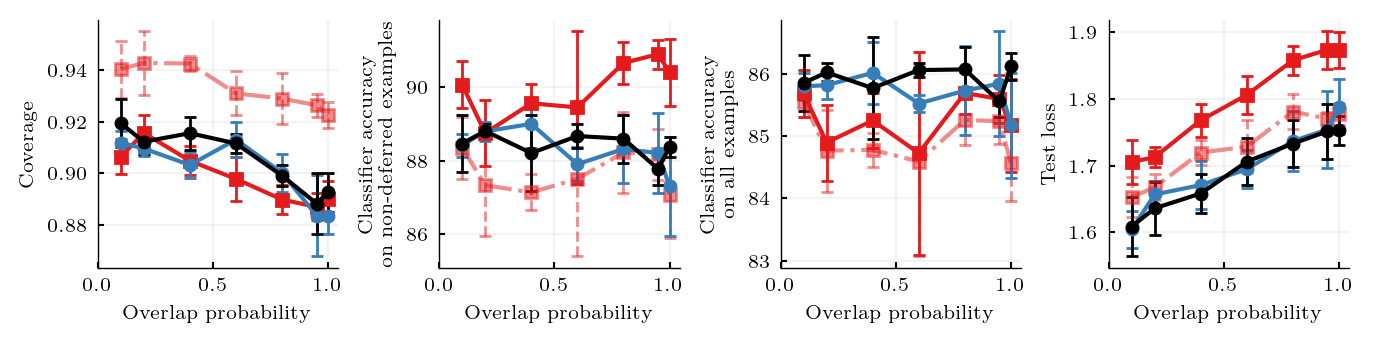

In [94]:
fig,axs = plt.subplots(1,4,figsize=(page_width,1.6), constrained_layout=True)

metric_to_col = {'single':c_red,'pop':c_blue, 'pop_attn':'k', 'single_finetune':c_red}
metric_to_marker = {'single':'s-','pop':'o-', 'pop_attn':'o-', 'single_finetune':'s-.'}
errbar_args={'capsize':2, 'markersize':4, 'elinewidth':1, 'capthick':1, 'lw':1.5} # 'fmt':'o-'

fs_ax_lbl=7
fs_ax_ticks = 7
fs_ax_title = 8

budget = 1.0
for ax,metric in zip(axs,['cov', 'clf_acc', 'clf_acc_alone', 'val_loss']):
    for l2d_type in l2d_type_lst:
        metric_mean = np.mean(results[l2d_type][budget][metric], axis=1)
        metric_std = np.std(results[l2d_type][budget][metric], axis=1)
        overlap_prob = np.array(p_out_lst)
        if l2d_type == 'single_finetune':
            eb1 = ax.errorbar(overlap_prob, metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], \
                    c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], alpha=0.5, **errbar_args)
            eb1[-1][0].set_linestyle('--')
        else:
            ax.errorbar(overlap_prob, metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], \
                    c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], **errbar_args)
    ax.set_xticks([0,0.5,1])
    
    ax.set_ylabel(metrics_to_text[metric], fontsize=fs_ax_lbl)
    ax.grid(True, alpha=0.15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(direction='in', labelsize=fs_ax_ticks,length=2., width=0.75)
    [x.set_linewidth(.5) for x in ax.spines.values()]
    ax.set_xlabel('Overlap probability', fontsize=fs_ax_lbl)

# # non-cifar20 legend
# handles, labels = axs[1].get_legend_handles_labels()
# order = [1,0,2]
# leg = fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], \
#                  fontsize=fs_ax_title,frameon=False,ncol=3,loc='upper center',bbox_to_anchor=(0.5, 1.15))
# leg.get_frame().set_linewidth(0.5)

# # cifar20 legend
# handles, labels = axs[1].get_legend_handles_labels()
# leg = fig.legend([handles[-1]],[labels[-1]], \
#                  fontsize=fs_ax_title,frameon=False,loc='upper center',bbox_to_anchor=(0.5, 1.15))
# leg.get_frame().set_linewidth(0.5)

# fig.savefig(f'exp_{ds_name}_supp.pdf', dpi=600, facecolor='white', bbox_inches='tight', pad_inches=0.01)

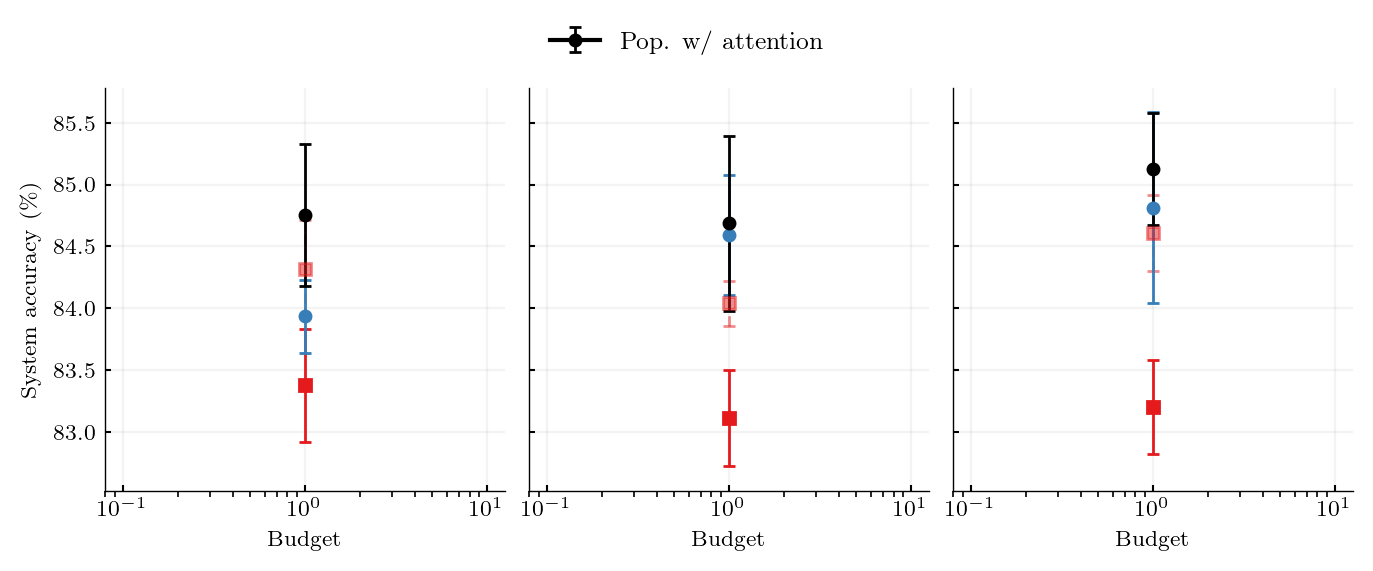

In [95]:
p_out_show_idx = [0,2,4]

fig,axs = plt.subplots(1,len(p_out_show_idx),figsize=(page_width,2.4), constrained_layout=True)
metric_show = 'sys_acc'

metric_to_col = {'single':c_red,'pop':c_blue, 'pop_attn':'k', 'single_finetune':c_red}
metric_to_marker = {'single':'s-','pop':'o-', 'pop_attn':'o-', 'single_finetune':'s-.'}
errbar_args={'capsize':2, 'markersize':4, 'elinewidth':1, 'capthick':1, 'lw':1.5} # 'fmt':'o-'

fs_ax_lbl=8
fs_ax_ticks = 8
fs_ax_title = 10
fs_ax_leg = 9

yvals_all = []
for idx_pout, ax in zip(p_out_show_idx,axs):
    for l2d_type in l2d_type_lst:
        res_all = np.vstack([results[l2d_type][budget][metric_show][idx_pout,:] for budget in budget_lst])
        metric_mean = np.mean(res_all, axis=1)
        metric_std = np.std(res_all, axis=1)
        if l2d_type == 'single_finetune':
            eb1 = ax.errorbar(np.array(budget_lst), metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], \
                    c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], alpha=0.5, **errbar_args)
            eb1[-1][0].set_linestyle('--')
        else:
            ax.errorbar(np.array(budget_lst), metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], \
                    c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], **errbar_args)
        yvals_all += [metric_mean-metric_std, metric_mean+metric_std]
    ax.set_xscale('log')
    ax.grid(True, alpha=0.15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(direction='in', labelsize=fs_ax_ticks,length=2., width=0.75)
    [x.set_linewidth(.5) for x in ax.spines.values()]
    ax.set_xlabel('Budget', fontsize=fs_ax_lbl)

axs[0].set_ylabel(metrics_to_text[metric_show], fontsize=fs_ax_lbl)
axs[1].tick_params(labelleft=False)
axs[2].tick_params(labelleft=False)

# consistent y-range across subplots
yvals_all = np.array(yvals_all)
buffer=0.2
for ax in axs:
    ax.set_ylim(yvals_all.min()-buffer, yvals_all.max()+buffer)
    
# # show overlap probability title
# for ax in axs:
#     ax.set_title(f'$p={p_out_lst[idx_pout]}$', fontsize=fs_ax_title)

# # non-cifar20 legend
# handles, labels = axs[1].get_legend_handles_labels()
# order = [1,0,2]
# leg = fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], \
#                  fontsize=fs_ax_leg,frameon=False,ncol=3,loc='upper center',bbox_to_anchor=(0.5, 1.15))
# leg.get_frame().set_linewidth(0.5)

# cifar20 legend
handles, labels = axs[1].get_legend_handles_labels()
leg = fig.legend([handles[-1]],[labels[-1]], \
                 fontsize=fs_ax_leg,frameon=False,loc='upper center',bbox_to_anchor=(0.5, 1.15))
leg.get_frame().set_linewidth(0.5)

# fig.savefig(f'exp_{ds_name}_supp_budget.pdf', dpi=600, facecolor='white', bbox_inches='tight', pad_inches=0.01)